# LDDMM: importance of the data attachment term

In [1]:
import shutil
from pathlib import Path

import numpy as np
import pyvista as pv
from matplotlib import pyplot as plt

import polpo.lddmm as plddmm
from polpo.mesh.qoi import centroid2farthest_vertex, vertexwise_euclidean
from polpo.mesh.surface import PvSurface
from polpo.mesh.varifold.tuning import SigmaFromLengths
from polpo.plot.pyvista import RegisteredMeshesColoredPlotter
from polpo.preprocessing.load.pregnancy.deformetrica import get_two_random_meshes

[KeOps] Warning : CUDA was detected, but driver API could not be initialized. Switching to CPU only.


In [2]:
RECOMPUTE = False

STATIC_VIZ = True
VIZ = 1

if STATIC_VIZ:
    pv.set_jupyter_backend("static")

In [3]:
STRUCT_NAME = "L_Hipp"


OUTPUTS_DIR = Path.home() / ".polpo/results" / f"lddmm_data_attachment_{STRUCT_NAME}"
REGISTRATION_DIR = OUTPUTS_DIR / "registration"


if OUTPUTS_DIR.exists() and RECOMPUTE:
    shutil.rmtree(OUTPUTS_DIR)

In [4]:
meshes = get_two_random_meshes(
    OUTPUTS_DIR,
    mesh_names=("source", "target"),
    target_reduction=0,
)

In [5]:
if VIZ > 1:
    pl = pv.Plotter(border=False)

    for mesh in meshes:
        pl.add_mesh(mesh.as_pv(), show_edges=True, opacity=0.6)

    pl.show()

Following [LDDMM: how to register a mesh to a template?](./lddmm_register_mesh_template.ipynb).

In [6]:
registration_kwargs = dict(
    kernel_width=4.0,
    regularisation=1.0,
    max_iter=2000,
    freeze_control_points=False,
    tol=1e-16,
)

registration_dirs = []
mesh_filenames = list(meshes.keys())

In [7]:
sigma_search = SigmaFromLengths(
    ratio_charlen_mesh=2.0,
    ratio_charlen=0.25,
)
sigma_search.fit(meshes.values())

varifold_metric = sigma_search.optimal_metric_

In [8]:
metric = "landmark"
registration_dir = REGISTRATION_DIR / metric
registration_dirs.append(registration_dir)


if not registration_dir.exists():
    plddmm.registration.estimate_registration(
        mesh_filenames[0],
        mesh_filenames[1],
        metric=metric,
        output_dir=registration_dir,
        **registration_kwargs,
    )

Logger has been set to: INFO
>> No initial CP spacing given: using diffeo kernel width of 4.0
OMP_NUM_THREADS was not found in environment variables. An automatic value will be set.
OMP_NUM_THREADS will be set to 10
context has already been set
>> No specified state-file. By default, Deformetrica state will by saved in file: /home/luisfpereira/.polpo/results/lddmm_data_attachment_L_Hipp/registration/landmark/deformetrica-state.p.
>> Using a Sobolev gradient for the template data with the ScipyLBFGS estimator memory length being larger than 1. Beware: that can be tricky.
>> Set of 420 control points defined.
>> Momenta initialized to zero, for 1 subjects.
>> Started estimator: ScipyOptimize

>> Scipy optimization method: L-BFGS-B

------------------------------------- Iteration: 1 -------------------------------------

------------------------------------- Iteration: 20 -------------------------------------
>> Log-likelihood = -4.152E+02 	 [ attachment = -2.133E+02 ; regularity = -2.019

NB: `use_svf=True` affects the deformation model, not the data attachment term. 

In [9]:
metric = "landmark"
registration_dir = REGISTRATION_DIR / f"{metric}_svf"
registration_dirs.append(registration_dir)


if not registration_dir.exists():
    plddmm.registration.estimate_registration(
        mesh_filenames[0],
        mesh_filenames[1],
        use_svf=True,
        metric=metric,
        output_dir=registration_dir,
        **registration_kwargs,
    )

Logger has been set to: INFO
>> No initial CP spacing given: using diffeo kernel width of 4.0
OMP_NUM_THREADS was not found in environment variables. An automatic value will be set.
OMP_NUM_THREADS will be set to 10
context has already been set
>> No specified state-file. By default, Deformetrica state will by saved in file: /home/luisfpereira/.polpo/results/lddmm_data_attachment_L_Hipp/registration/landmark_svf/deformetrica-state.p.
>> Using a Sobolev gradient for the template data with the ScipyLBFGS estimator memory length being larger than 1. Beware: that can be tricky.
>> Set of 420 control points defined.
>> Momenta initialized to zero, for 1 subjects.
>> Started estimator: ScipyOptimize

>> Scipy optimization method: L-BFGS-B

------------------------------------- Iteration: 1 -------------------------------------

------------------------------------- Iteration: 20 -------------------------------------
>> Log-likelihood = -4.341E+02 	 [ attachment = -2.262E+02 ; regularity = -2

In [10]:
metric = "varifold"
registration_dir = REGISTRATION_DIR / metric
registration_dirs.append(registration_dir)


if not registration_dir.exists():
    plddmm.registration.estimate_registration(
        mesh_filenames[0],
        mesh_filenames[1],
        metric=metric,
        output_dir=registration_dir,
        attachment_kernel_width=sigma_search.sigma_,
        **registration_kwargs,
    )

Logger has been set to: INFO
>> No initial CP spacing given: using diffeo kernel width of 4.0
OMP_NUM_THREADS was not found in environment variables. An automatic value will be set.
OMP_NUM_THREADS will be set to 10
context has already been set
>> No specified state-file. By default, Deformetrica state will by saved in file: /home/luisfpereira/.polpo/results/lddmm_data_attachment_L_Hipp/registration/varifold/deformetrica-state.p.
>> Using a Sobolev gradient for the template data with the ScipyLBFGS estimator memory length being larger than 1. Beware: that can be tricky.
>> Set of 420 control points defined.
>> Momenta initialized to zero, for 1 subjects.
>> Started estimator: ScipyOptimize

>> Scipy optimization method: L-BFGS-B

------------------------------------- Iteration: 1 -------------------------------------

------------------------------------- Iteration: 20 -------------------------------------
>> Log-likelihood = -2.891E+02 	 [ attachment = -1.325E+02 ; regularity = -1.566

In [11]:
metric = "varifold"
registration_dir = REGISTRATION_DIR / f"{metric}_svf"
registration_dirs.append(registration_dir)


if not registration_dir.exists():
    plddmm.registration.estimate_registration(
        mesh_filenames[0],
        mesh_filenames[1],
        metric=metric,
        use_svf=True,
        output_dir=registration_dir,
        attachment_kernel_width=sigma_search.sigma_,
        **registration_kwargs,
    )

Logger has been set to: INFO
>> No initial CP spacing given: using diffeo kernel width of 4.0
OMP_NUM_THREADS was not found in environment variables. An automatic value will be set.
OMP_NUM_THREADS will be set to 10
context has already been set
>> No specified state-file. By default, Deformetrica state will by saved in file: /home/luisfpereira/.polpo/results/lddmm_data_attachment_L_Hipp/registration/varifold_svf/deformetrica-state.p.
>> Using a Sobolev gradient for the template data with the ScipyLBFGS estimator memory length being larger than 1. Beware: that can be tricky.
>> Set of 420 control points defined.
>> Momenta initialized to zero, for 1 subjects.
>> Started estimator: ScipyOptimize

>> Scipy optimization method: L-BFGS-B

------------------------------------- Iteration: 1 -------------------------------------

------------------------------------- Iteration: 20 -------------------------------------
>> Log-likelihood = -3.112E+02 	 [ attachment = -1.494E+02 ; regularity = -1

In [12]:
source, target = meshes.values()

reconstructed = {}
for registration_dir in registration_dirs:
    reconstructed[registration_dir.name] = PvSurface(
        plddmm.io.load_deterministic_atlas_reconstruction(registration_dir, as_pv=True)
    )

reconstructed["source"] = source

In [13]:
{
    name: varifold_metric.dist(target, reconstructed_)
    for name, reconstructed_ in reconstructed.items()
}

{'landmark': np.float64(15.674591642516685),
 'landmark_svf': np.float64(16.995952344389686),
 'varifold': np.float64(5.41578435415065),
 'varifold_svf': np.float64(5.6515407334274705),
 'source': np.float64(141.32513317492763)}

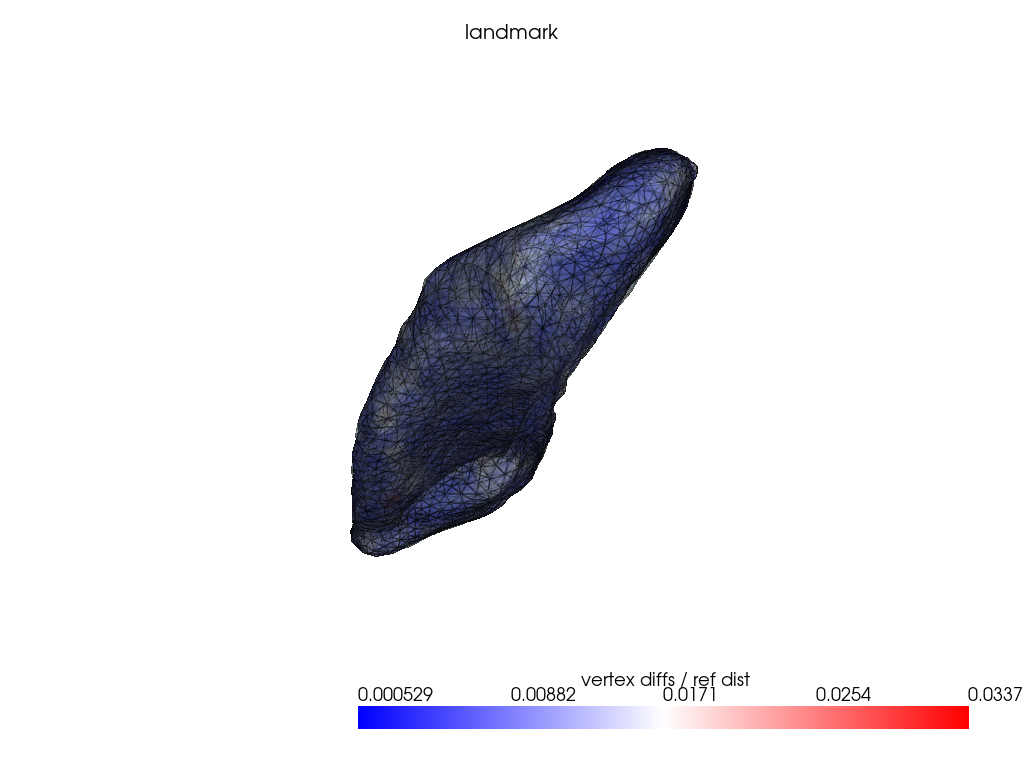

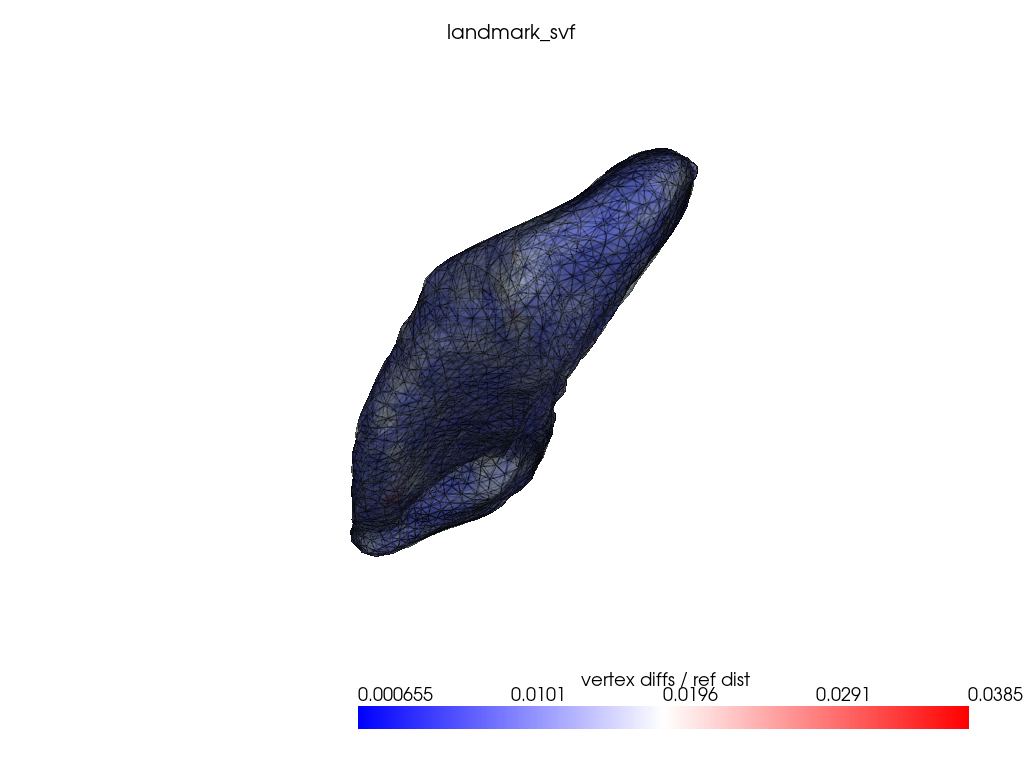

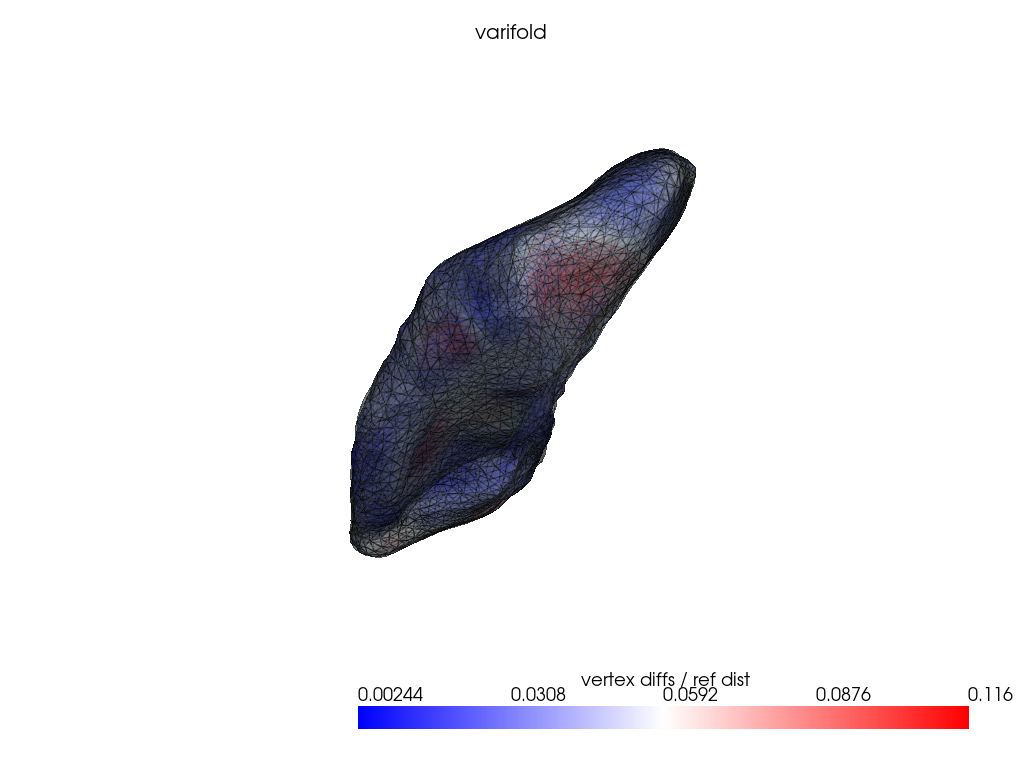

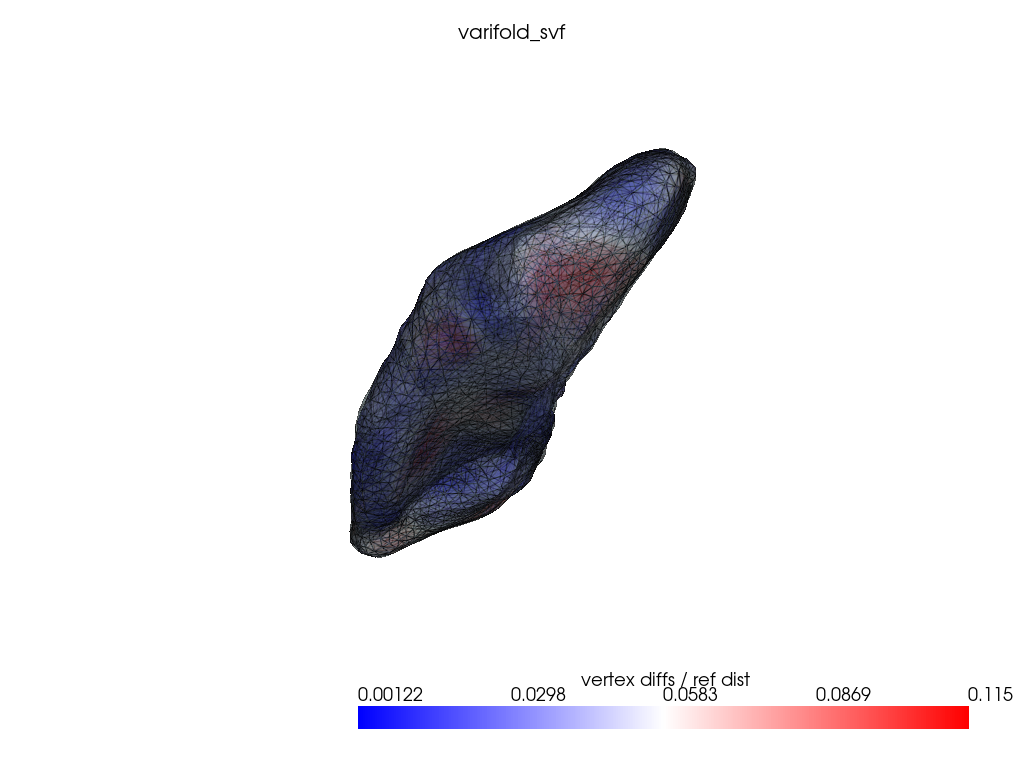

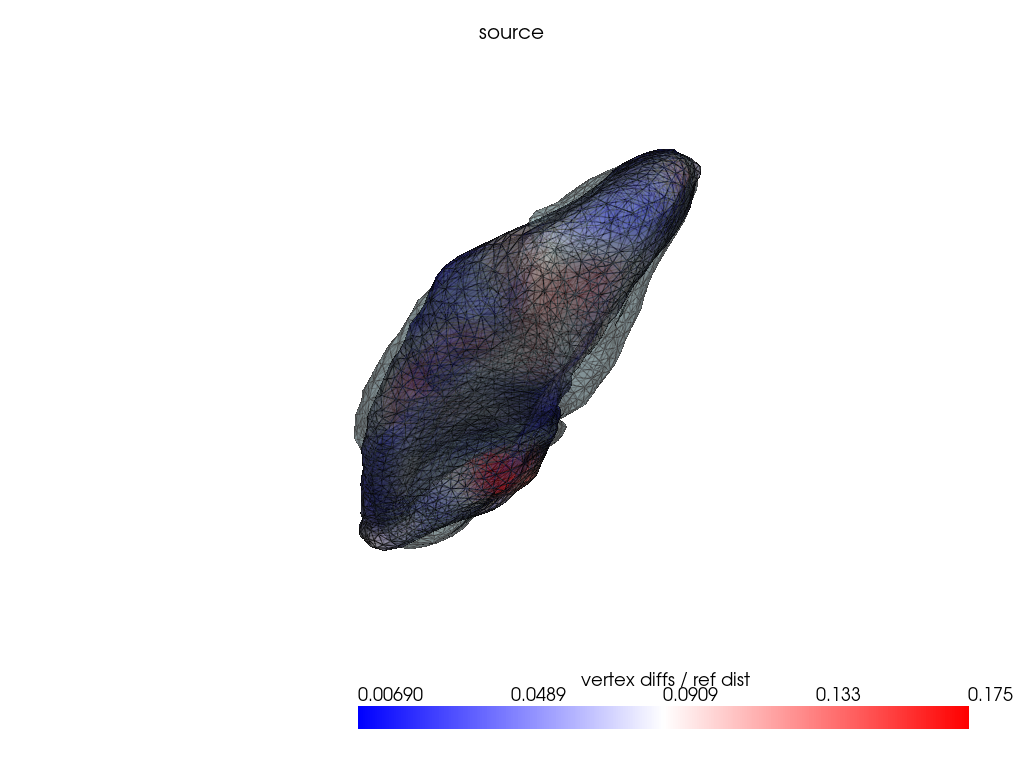

In [14]:
if VIZ > 0:
    ref_dist = centroid2farthest_vertex([target])[0]

    for name, reconstructed_ in reconstructed.items():
        pl = RegisteredMeshesColoredPlotter()

        pl.add_meshes(
            target.as_pv(),
            reconstructed_.as_pv(),
            ref_dist=ref_dist,
            show_edges=True,
            opacity=0.8,
            name="vertex diffs / ref dist",
        )

        pl.add_mesh(reconstructed_.as_pv(), show_edges=True, opacity=0.5)

        pl.add_title(name, font_size=8.0)

        pl.show()

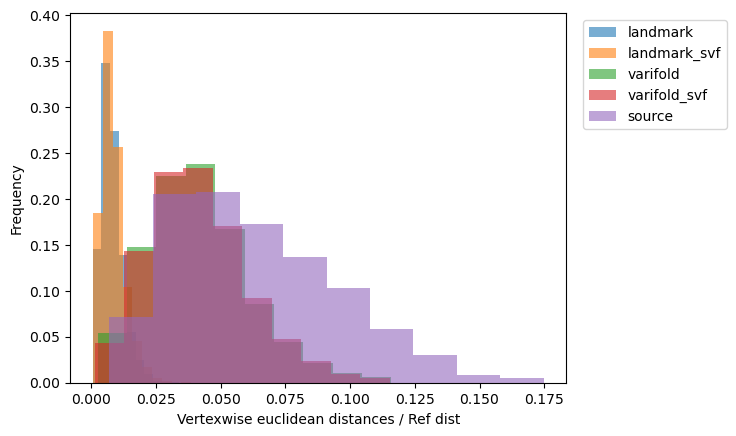

In [15]:
_, ax = plt.subplots()

for name, reconstructed_ in reconstructed.items():
    vals = vertexwise_euclidean(target, reconstructed_) / ref_dist

    ax.hist(
        vals,
        weights=1 / len(vals) * np.ones_like(vals),
        label=name,
        alpha=0.6,
    )

ax.set_xlabel("Vertexwise euclidean distances / Ref dist")
ax.set_ylabel("Frequency")

ax.legend(bbox_to_anchor=(1.02, 1), loc="upper left");

# Further reading

* [LDDMM: influence of control points location](./lddmm_control_points.ipynb)

* [LDDMM: influence of regularisation](./lddmm_regularisation.ipynb)

* [LDDMM: influence of time points](./lddmm_time_points.ipynb)